In [95]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
url = 'E:\App Exes\VS Code\Proyecto Final Data\healthcare-dataset-stroke-data.csv'

In [96]:
df = pd.read_csv(url, sep = ',')
df = pd.get_dummies(df, columns=['work_type'], prefix='work_type')
df = pd.get_dummies(df, columns=['smoking_status'], prefix='smoking_status')
#Reemplaza valores nulos de BMI promediando por rango edades cercanas
promedio_bmi_edades = df.groupby('age')['bmi'].mean()
df['bmi'] = df.apply(lambda row: promedio_bmi_edades[row['age']] if pd.isnull(row['bmi']) else row['bmi'], axis=1)

#Reemplazo valores strings por valores numericos
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0, 'Other': 2})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})

df_stroke = df.loc[df['stroke'] == 1]
df_nostroke = df.loc[df['stroke'] == 0]

C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


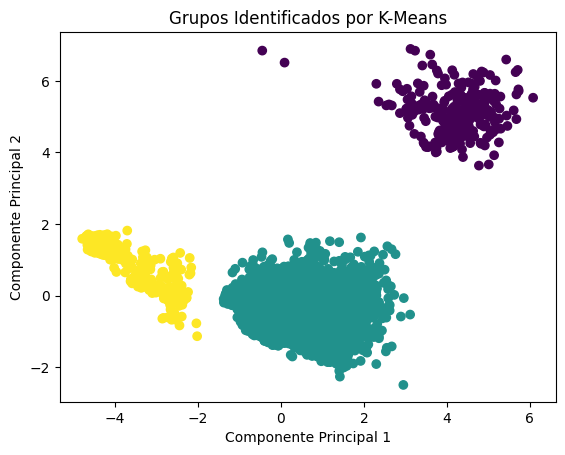

In [112]:
# Seleccionar las características para el análisis de clustering
X = df

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para encontrar clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Agregar la columna de clusters al DataFrame original
df['cluster'] = clusters

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los grupos en un scatterplot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Grupos Identificados por K-Means")
plt.show()


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


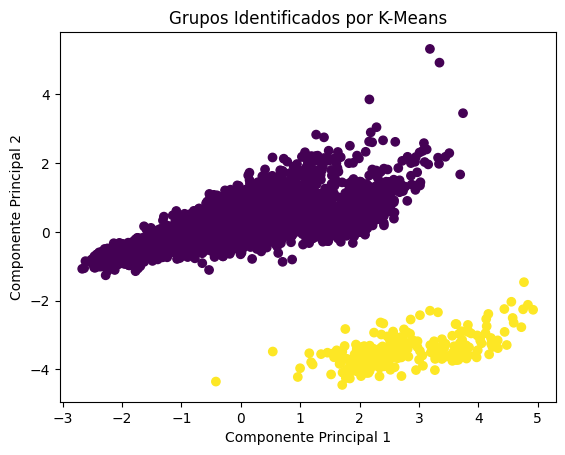

In [98]:
# Seleccionar las características para el análisis de clustering
X = df[['age', 'avg_glucose_level', 'bmi', 'stroke']]

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para encontrar clusters
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Agregar la columna de clusters al DataFrame original
df['cluster2'] = clusters

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los grupos en un scatterplot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Grupos Identificados por K-Means")
plt.show()


Precisión en datos de entrenamiento: 0.9997553816046967
Precisión en datos de prueba: 1.0


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

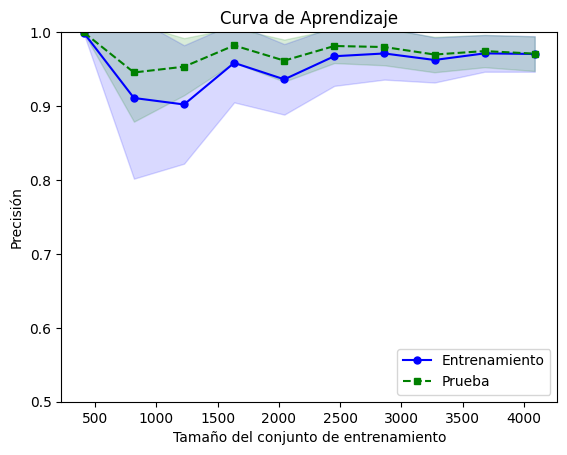

In [100]:
# Seleccionar las características y la variable objetivo para df
X = df.drop(columns = "stroke")
y = df['stroke']

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

# Crear el modelo de regresión logística
reg = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
reg.fit(X_train, y_train)

# Predecir los valores de stroke para los datos de entrenamiento y prueba
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calcular la precisión para los datos de entrenamiento y prueba
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("Precisión en datos de entrenamiento:", train_acc)
print("Precisión en datos de prueba:", test_acc)

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(reg, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcular las medias y desviaciones estándar de las puntuaciones de entrenamiento y prueba
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.show()

In [101]:
# Calcular el F1-score para los datos de entrenamiento y prueba
train_f1 = f1_score(y_train, train_pred)
test_f1 = f1_score(y_test, test_pred)

print("F1-score en datos de entrenamiento:", train_f1)
print("F1-score en datos de prueba:", test_f1)

F1-score en datos de entrenamiento: 0.9974937343358395
F1-score en datos de prueba: 1.0


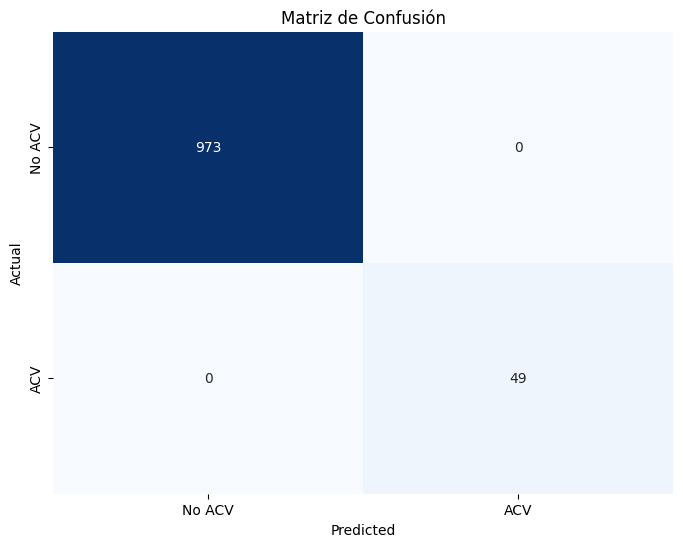

In [102]:
# Obtener las predicciones del modelo para los datos de prueba
y_pred = reg.predict(X_test)

# Crear la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Crear un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.xticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.yticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.show()